In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Dimitri\workspaces\quantum\quantum-machine-learning


# Architecture of Quantum Variational Classifier

![Machine Learning System](qml.jpg)

- The Feature Map encodes the input data - a numerical vector - into a quantum state.
- The Machine Learning Model is implemented with a Quantum Circuit, which transforms the quantum state. The circuit has several tunable parameters like a regular machine learning model
- The output of the circuit is obtained by means of a measurement of the quantum state. This measurement is probabilistic and will in general give a random outcome, but with known probability distribution. This is more or less equivalent to the activation functions on the neuron.
- The outputs of the classifier, together with the actual outputs are fed into an optimizer which is implemented on a classical computer.


# Quantum Encoding - Feature Maps

The first step in a quantum circuit is to encode the classical state vector into a quantum circuit by mapping an n-dimensional vector v to a m quits

Some commonly used embeddings are:

- Basic Encoding: Represent a number as a bit sequence and represent each bit as a qubit. This encoding is requires too many qubits for a typical ML problem unless dealing with binary data.

- Angle Encoding: Rotate each qubit by an angle corresponding to each value in the vector. The vector must be rescaled first. This embeds an n-dim vector into n qubits

- Amplitude Encoding: Each vector is encoded as a real amplitude. Since an n-qubit vector has 2^n amplitudes, this encoding achieves a logarithmic compression of the input, making it ver desirable for high dimensional data sets. However, each input vector must be normalized to have (Hilbert) norm = 1.

- Kernel Encodings (eg ZZFeatureMap) - TODO
    - ZFeatureMap
    - ZZFeatureMap
    - PauliFeatureMap



# Amplitde Embedding Failure

Whereas Amplitude Embedding appears to offer significant compression, it performs poorly in training QVMs. Let's look at an example of training a QVM to  the classic Wisconsin Breast Cancer Data set. The data set has 30 predictors, which means that we only need 5 qubits to represent the entire data set using Amplitude Embedding. We would need 30 qubit to represent the same data set using Angle Embedding, which is prohibitive for a simulator. 

In order to use Angle Embedding we will apply preprocessing with PCA and reduce the data set to 5 features corresponding to the first 5 principal components.


In [7]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris, load_breast_cancer
import numpy as np
import matplotlib.pyplot as plt
from utils.preprocess import scale_for_angle_encoding, scale_for_amplitude_encoding
from utils.reporting import HistoryTracker
from penny.classifier import BinaryClassifier, ClassifierContext
from penny.models import *

In [8]:
# Get the dataset, scale, and divide into training and test set

features, y = load_breast_cancer(return_X_y=True)
# convert from 0/1 to -1/1
y[y == 0] = -1
# scale
X = StandardScaler().fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2)

In [9]:
# Use PCA to prepare for Angle Encoding

num_features = 5

pca = PCA(n_components=num_features)
X_train_pca = pca.fit_transform(X_train)
X_train_scaled = scale_for_angle_encoding(X_train_pca)
X_test_pca = pca.transform(X_test)
X_test_scaled = scale_for_angle_encoding(X_test_pca)

In [12]:
angle_history_tracker = HistoryTracker(X_train_scaled, y_train)
num_qubits = num_features
num_layers = 3
classifier = BinaryClassifier(model=StronglyEntangledBinaryModel(num_qubits),
                                  weights_shape=(3, num_qubits, 3),
                                  device="lightning.qubit",
                                  iterations=100,
                                  report_fn=angle_history_tracker)
classifier.fit(X_train_scaled, y_train)

Iter:    10 | Accuracy: 0.4307692 
Iter:    20 | Accuracy: 0.5824176 
Iter:    30 | Accuracy: 0.6351648 
Iter:    40 | Accuracy: 0.6351648 
Iter:    50 | Accuracy: 0.7340659 
Iter:    60 | Accuracy: 0.8879121 
Iter:    70 | Accuracy: 0.9208791 
Iter:    80 | Accuracy: 0.9164835 
Iter:    90 | Accuracy: 0.9164835 
Iter:   100 | Accuracy: 0.9120879 


In [13]:
# Classification results
predictions_test = classifier.predict(X_test_scaled)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

          -1       0.73      0.80      0.76        40
           1       0.89      0.84      0.86        74

    accuracy                           0.82       114
   macro avg       0.81      0.82      0.81       114
weighted avg       0.83      0.82      0.83       114



In [14]:
# Now train using Amplitude Encoding

X_train_ampl = scale_for_amplitude_encoding(X_train)
X_test_ampl = scale_for_amplitude_encoding(X_test)

amplitude_history_tracker = HistoryTracker(X_train_ampl, y_train)

num_qubits = 5
model = StronglyEntangledBinaryModel(num_qubits, embedding_fn=amplitude_embedding_fn)
classifier = BinaryClassifier(model=model,
                                  weights_shape=(3, num_qubits, 3),
                                  device="lightning.qubit",
                                  iterations=100,
                                  report_fn=amplitude_history_tracker)
classifier.fit(X_train_ampl, y_train)

Iter:    10 | Accuracy: 0.6505495 
Iter:    20 | Accuracy: 0.6461538 
Iter:    30 | Accuracy: 0.6527473 
Iter:    40 | Accuracy: 0.6615385 
Iter:    50 | Accuracy: 0.6571429 
Iter:    60 | Accuracy: 0.6549451 
Iter:    70 | Accuracy: 0.6615385 
Iter:    80 | Accuracy: 0.6945055 
Iter:    90 | Accuracy: 0.6659341 
Iter:   100 | Accuracy: 0.6835165 


In [16]:
predictions_test = classifier.predict(X_test)
cr = classification_report(y_test, predictions_test)
print(cr)

              precision    recall  f1-score   support

          -1       0.45      0.60      0.52        40
           1       0.74      0.61      0.67        74

    accuracy                           0.61       114
   macro avg       0.60      0.60      0.59       114
weighted avg       0.64      0.61      0.61       114



<Axes: title={'center': 'Angle vs Amplitude Encoding'}>

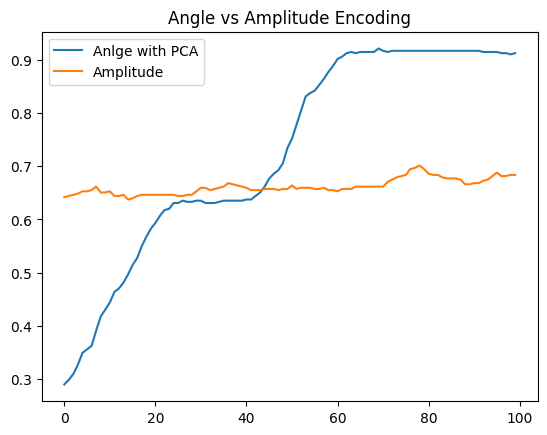

In [18]:
# Compare results

import pandas as pd

df = pd.DataFrame(list(zip(angle_history_tracker.history, amplitude_history_tracker.history)), 
                  columns=['Anlge with PCA', 'Amplitude'])
df.plot(title='Angle vs Amplitude Encoding')

Clearly, there is something wrong with raw Amplitude Encoding. 